In [4]:
import numpy as np
import pandas as pd
import nilearn

In [6]:
from nilearn import datasets

dataset = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
atlas_filename = dataset.maps
labels = dataset.labels
print(f"Atlas ROIs are located in nifti image (4D) at: {atlas_filename}")

Atlas ROIs are located in nifti image (4D) at: 
<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine:
[[   2.    0.    0.  -90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 2. 2. 2. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform

In [50]:
# One subject of brain development fmri data
data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=True)
fmri_filenames = data.func[0]
reduced_confounds = data.confounds[0]  # This is a preselected set of confounds

In [11]:
# load .dcm files for nilearn
import pydicom as dicom

image_path = 'RAW_PPMI/3102/ep2d_RESTING_STATE/2013-02-06_10_38_32.0/I378209/PPMI_3102_MR_ep2d_RESTING_STATE_br_raw_20130626124735840_52_S193424_I378209.dcm'
directory_series = 'RAW_PPMI/3102/ep2d_RESTING_STATE/2013-02-06_10_38_32.0/I378209/'
ds = dicom.dcmread(image_path)


In [15]:
# convert to nifti (3D/4D Niimg-like object)
import dicom2nifti

dicom2nifti.convert_directory(directory_series, 'nifti_series', compression=True, reorient=True)

In [23]:
from nilearn.maskers import NiftiLabelsMasker

masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

In [37]:
# get path to files in 'nifti_series'
import os

path = 'nifti_series'
files = os.listdir(path)
files.sort()
files = [os.path.join(path, file) for file in files]
# no DS_Store
files = files[1:]

In [40]:
from nilearn import image
img  = nilearn.image.load_img(files[0])
print(img)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (68, 66, 40, 210)
affine:
[[ -3.29411769   0.          -0.         107.27710724]
 [ -0.           3.29411769  -0.         -79.77320862]
 [  0.          -0.           3.29999995 -79.86807251]
 [  0.           0.           0.           1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  68  66  40 210   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         3.2941177  3.2941177  3.3        1.         1.
  1.         1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slic

In [42]:
time_series = masker.fit_transform(img)

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x158a93a10>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x158aac6d0>, { 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x158514610>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': 'zscore_sample',
  'standardize_confounds': 'zscore_sample',
  'strategy': 'mean',
  't_r': None,
  't

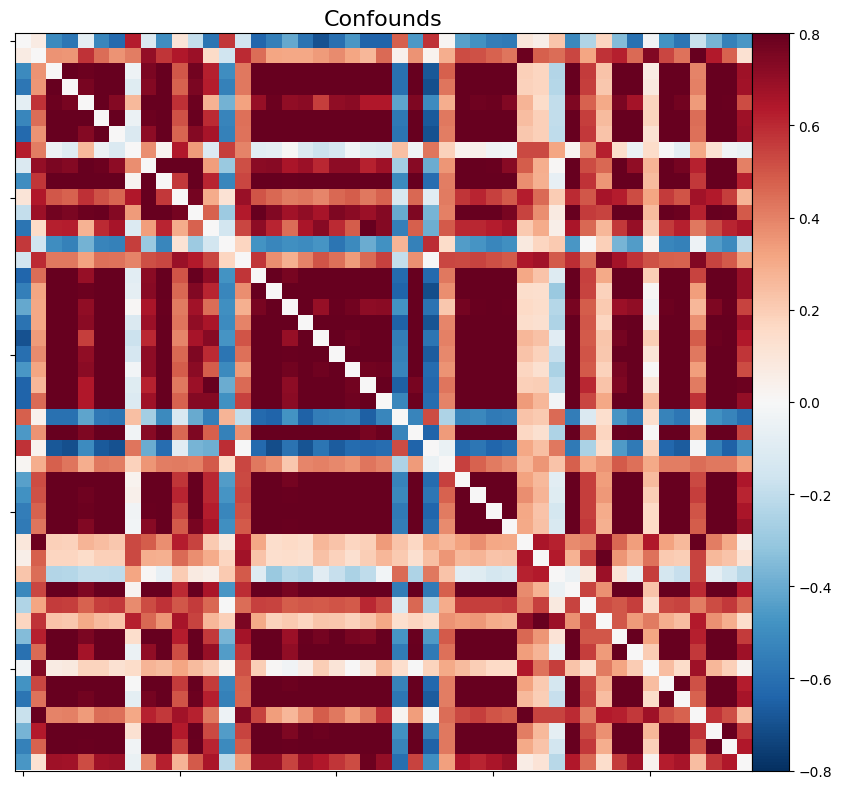

In [45]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Plot the correlation matrix
import numpy as np

from nilearn import plotting

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    vmax=0.8,
    vmin=-0.8,
    title="Confounds",
)

In [49]:
correlation_matrix.shape

(47, 47)